<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/william-dove/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install Libraries, Enable GPU Acceleration

In [3]:
!pip install astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.2 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 2. Load FITS Image

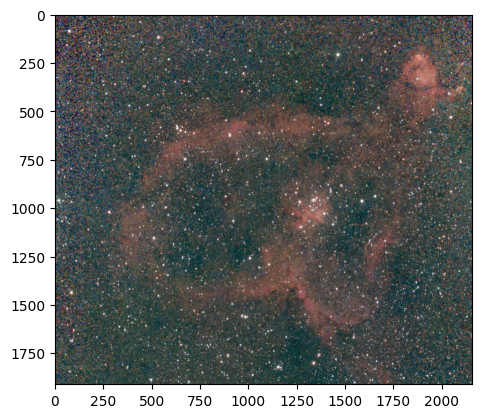

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from auto_stretch import apply_stretch
from sklearn.cluster import KMeans
import requests
from io import BytesIO

# Replace this URL with the raw URL of your FITS file on GitHub in https://github.com/ubsuny/PHY386/tree/main/data
# Check https://github.com/ubsuny/PHY386/blob/main/2025/HW/HW5-assignment.csv for the fits file assigned to you
fits_url = "https://github.com/ubsuny/PHY386/raw/refs/heads/main/data/12up.fits" # Replaced with my URL.

# Fetch the FITS file from the GitHub repository
response = requests.get(fits_url)
response.raise_for_status()  # Check for request errors

# Load the FITS file into an HDUList using BytesIO
hdul = fits.open(BytesIO(response.content))

# Assume the first extension contains an RGB image in (3, Height, Width) format
rgb_data = np.transpose(hdul[0].data, (1, 2, 0))  # Shape should be (3, Height, Width)
hdul.close() #

# Display the image
fig = plt.figure()
plt.imshow(apply_stretch(rgb_data))

# 3. Count Stars Using Astropy

In [34]:
def detect_stars(channel_data):
    """
    Detects stars in a 2D image using the DAOStarFinder algorithm.

    This function estimates the background statistics of the image using
    sigma-clipped statistics, then identifies star-like sources based on
    a Full Width at Half Maximum (FWHM) and a signal threshold.

    Parameters
    ----------
    channel_data : array_like
        A 2D NumPy array representing a single image channel (e.g., from a FITS image)
        where stars are to be detected. Pixel intensities should be linear (not log-scaled)
        and background-subtracted if possible.

    Returns
    -------
    astropy.table.Table
        A table of detected star sources, each with properties such as centroid
        positions, flux, sharpness, and roundness. Returns an empty table if no
        stars are found.

    Notes
    -----
    - Uses sigma-clipped statistics to robustly estimate the background mean,
      median, and standard deviation, excluding outliers like bright stars.
    - The DAOStarFinder algorithm identifies point sources based on their
      shape and brightness.
    - The detection threshold is set to 15 times the estimated background
      standard deviation, and the assumed FWHM of stars is 3 pixels.

    Examples
    --------
    >>> from astropy.io import fits
    >>> from astropy.stats import sigma_clipped_stats
    >>> from photutils.detection import DAOStarFinder
    >>> image_data = fits.getdata('example_image.fits')
    >>> stars = detect_stars(image_data)
    >>> print(len(stars))  # Number of stars detected
    """
    mean, median, std = sigma_clipped_stats(channel_data, sigma=3.0)
    finder = DAOStarFinder(fwhm=3.0, threshold=15.0*std)
    return finder(channel_data - median)

def equalize_channels(rgb_data):
  '''
  This function takes in the RGB channel data and counts the "stars" in each channel.
  It makes sure the number of stars are the same for each by finding which channel has the least stars and
  making the other channels only contain that same number of stars.
  The stars removed start with the least bright, leaving only the brightest stars.
  '''
  # Exctract RGB channels seperately
  r_channel = rgb_data[:, :, 0]
  g_channel = rgb_data[:, :, 1]
  b_channel = rgb_data[:, :, 2]

  # Count the stars in each channel
  r_sources = detect_stars(r_channel)
  g_sources = detect_stars(g_channel)
  b_sources = detect_stars(b_channel)

  # sort by brightness
  r_sources.sort('peak')
  g_sources.sort('peak')
  b_sources.sort('peak')

  # Find the number of stars in the least bright channel
  min_stars = min(len(r_sources), len(g_sources), len(b_sources))

  # Keep only the stars in the least bright channel
  r_sources = r_sources[:min_stars]
  g_sources = g_sources[:min_stars]
  b_sources = b_sources[:min_stars]

  return r_sources, g_sources, b_sources, min_stars


# calculate the mean of the RGB channels
avg_channel = np.mean(rgb_data[:, :, :], axis=2)

# Detect stars
mean_sources = detect_stars(avg_channel)
mean_sources.sort('peak')
r_sources, g_sources, b_sources, min_stars = equalize_channels(rgb_data)
mean_sources_brightest = mean_sources[:min_stars]

print(f"Number of detected stars: {len(mean_sources)}") # The number of stars calculated from the average of the channels
print(f"Number of detected stars within brightness of RGB stars: {len(mean_sources_brightest)}") # Number of stars from the average channel, with as many as were calculated from R, G and B
print(f"Number of detected red stars: {len(r_sources)}") # The number of stars should be the same for each channel.
print(f"Number of detected green stars: {len(g_sources)}")
print(f"Number of detected blue stars: {len(b_sources)}")

Number of detected stars: 1703
Number of detected stars within brightness of RGB stars: 1283
Number of detected red stars: 1283
Number of detected green stars: 1283
Number of detected blue stars: 1283


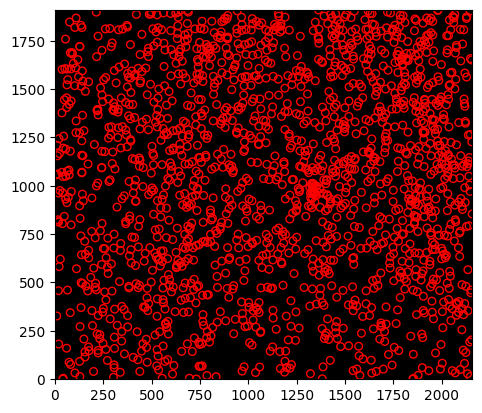

In [9]:
# Plot detected stars (average channel)
plt.imshow(avg_channel, cmap='gray', origin='lower')
plt.scatter(mean_sources['xcentroid'], mean_sources['ycentroid'], s=30, edgecolor='red', facecolors='none')
plt.show()

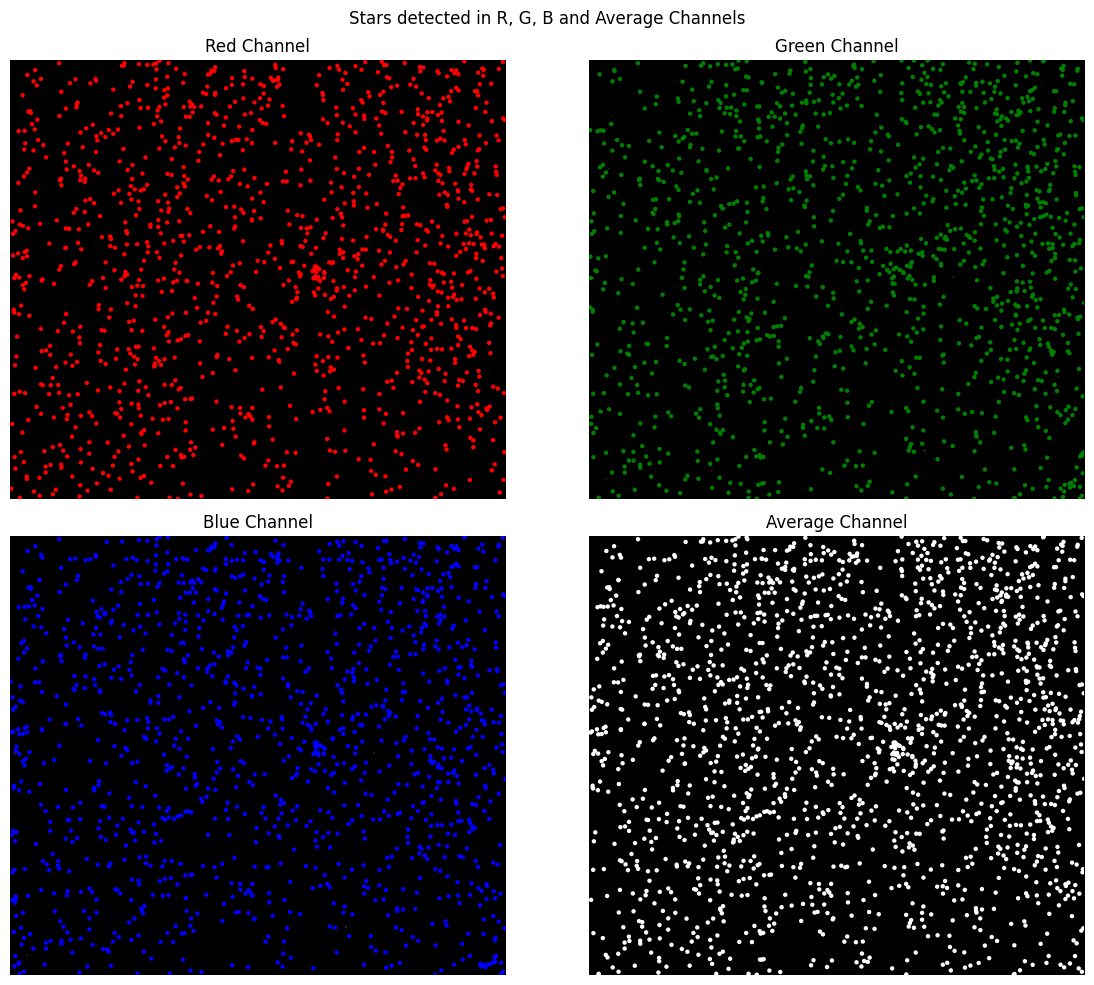

In [21]:
# 4-Sectioned plot:

# Extract the channel data
r_channel = rgb_data[:, :, 0]
g_channel = rgb_data[:, :, 1]
b_channel = rgb_data[:, :, 2]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Stars detected in R, G, B and Average Channels')
titles = ['Red Channel', 'Green Channel', 'Blue Channel', 'Average Channel']
channels = [r_channel, g_channel, b_channel, avg_channel]
sources = [r_sources, g_sources, b_sources, mean_sources]
colors = ['red', 'green', 'blue', 'white']

# Plot the stars for each channel
from photutils.aperture import CircularAperture # To draw circles around the stars
for ax, channel, sources, title, color in zip(axes.ravel(), channels, sources, titles, colors):
  ax.imshow(channel, cmap='gray', origin='lower')
  positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
  apertures = CircularAperture(positions, r=5.0)
  apertures.plot(ax, color=color, lw=1.5)
  ax.set_title(title)
  ax.axis('off')

plt.tight_layout()
plt.show()

## Feature Extraction

In [36]:
# Extract features (brightness and size)
flux = mean_sources_brightest['flux']

# Compute size proxy
size = mean_sources_brightest['sharpness']

# Calculate color ratios of the sources

rg = r_sources['flux'] / g_sources['flux']
bg = b_sources['flux'] / g_sources['flux']

# Normalize features
flux_norm = (flux - np.min(flux)) / (np.max(flux) - np.min(flux))
size_norm = (size - np.min(size)) / (np.max(size) - np.min(size))
rg_norm = (rg - np.min(rg)) / (np.max(rg) - np.min(rg))
bg_norm = (bg - np.min(bg)) / (np.max(bg) - np.min(bg))

features = np.vstack([flux_norm, size_norm, rg_norm, bg_norm]).T

# 4. Autoencoder for Feature Compression

In [37]:
# Define an autoencoder model
input_layer = Input(shape=(4,)) # Updated to 4 features to make room for the r/g and b/g color ratios added in "Feature Extraction."
encoded = Dense(16, activation='relu')(input_layer) # Doubled the neurons to match the features in each layer.
encoded = Dense(4, activation='relu')(encoded)

decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(4, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
autoencoder.fit(features, features, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1156
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0679
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0242
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0036
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037
Epoch 13/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035
Epoch 14/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 15/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 16/50
81/81 ━

# 5. Clustering with kmeans

In [38]:
encoder = Model(input_layer, encoded)
encoded_features = encoder.predict(features)

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(encoded_features)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


# 6a. Generating Synthetic Star Data

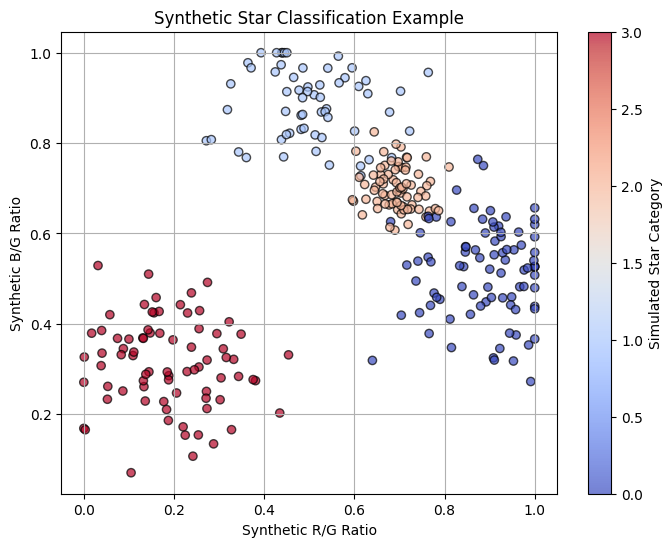

In [39]:
import random

def generate_synthetic_stars(num_stars=300):
    """Generates synthetic star data with predefined color and brightness properties."""
    categories = {
        0: {'rg': 0.9, 'bg': 0.5, 'scatter': 0.1},  # Red stars
        1: {'rg': 0.5, 'bg': 0.9, 'scatter': 0.1},  # Blue stars
        2: {'rg': 0.7, 'bg': 0.7, 'scatter': 0.05}, # White stars
        3: {'rg': 0.2, 'bg': 0.3, 'scatter': 0.1},  # Dim stars
    }

    stars = []
    labels = []

    for _ in range(num_stars):
        category = random.choice(list(categories.keys()))
        base = categories[category]
        rg = max(0, min(1, np.random.normal(base['rg'], base['scatter'])))
        bg = max(0, min(1, np.random.normal(base['bg'], base['scatter'])))
        stars.append([rg, bg])
        labels.append(category)

    return np.array(stars), np.array(labels)

# Generate and plot synthetic stars
synthetic_stars, synthetic_labels = generate_synthetic_stars()
plt.figure(figsize=(8,6))
plt.scatter(synthetic_stars[:,0], synthetic_stars[:,1], c=synthetic_labels, cmap='coolwarm', alpha=0.7, edgecolors='k')
plt.xlabel('Synthetic R/G Ratio')
plt.ylabel('Synthetic B/G Ratio')
plt.colorbar(label='Simulated Star Category')
plt.title('Synthetic Star Classification Example')
plt.grid(True)
plt.show()

# 6b. Visualizing Real Data

## Plotting Size vs. Brightness (example)

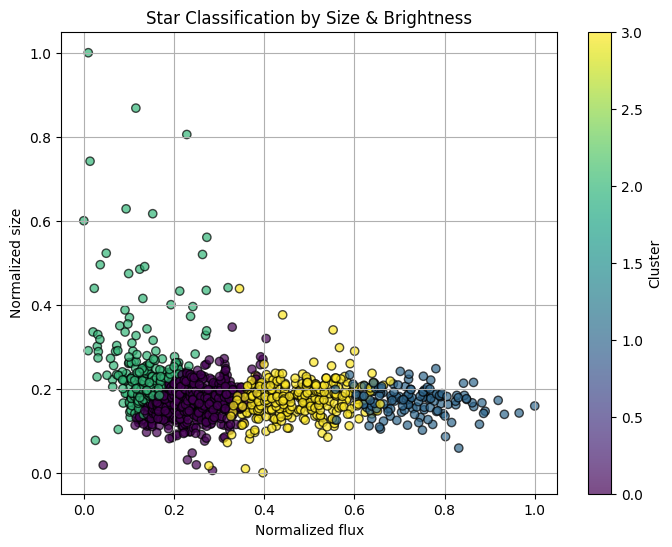

In [40]:
plt.figure(figsize=(8,6))
plt.scatter(flux_norm, size_norm, c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized flux')
plt.ylabel('Normalized size')
plt.colorbar(label='Cluster')
plt.title('Star Classification by Size & Brightness')
plt.grid(True)
plt.show()

## Plotting b/g vs. r/g ratios

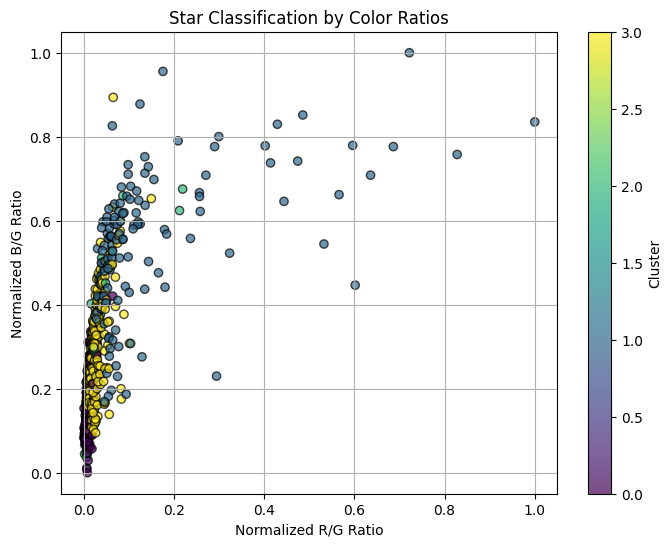

In [44]:
plt.figure(figsize=(8,6))
plt.scatter(rg_norm, bg_norm, c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized R/G Ratio')
plt.ylabel('Normalized B/G Ratio')
plt.colorbar(label='Cluster')
plt.title('Star Classification by Color Ratios')
plt.grid(True)
plt.show()

# 7. Refining the Clustering

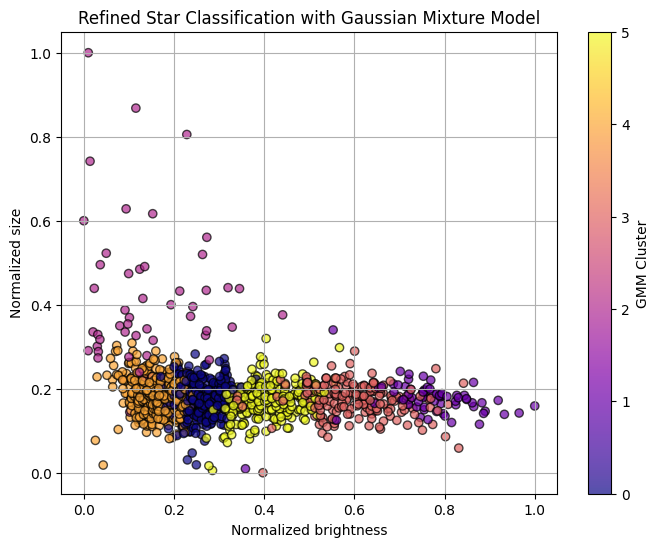

In [45]:
from sklearn.mixture import GaussianMixture

# Try different numbers of clusters
num_clusters_gmm = 6
gmm = GaussianMixture(n_components=num_clusters_gmm, random_state=42)
predicted_labels_gmm = gmm.fit_predict(encoded_features)

plt.figure(figsize=(8,6))
plt.scatter(flux_norm, size_norm, c=predicted_labels_gmm, cmap='plasma', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized brightness')
plt.ylabel('Normalized size')
plt.colorbar(label='GMM Cluster')
plt.title('Refined Star Classification with Gaussian Mixture Model')
plt.grid(True)
plt.show()